`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`pip install git+https://github.com/jbusecke/cmip6_preprocessing.git`

`mv *.png ../figures`

In [2]:
import xarray as xr
import xesmf as xe
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables
import statistics as stat

In [3]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

In [4]:

def calc_PpCO2_graeme(ds):
    results = pyco2.sys(par1=ds['talk']*1035.0,par2=ds['dissic']*1035.0,par1_type=1,par2_type=2,
                        pressure=0)
    return ds['talk'].copy(data=results['pCO2'])

def calc_PpCO2(ds):
    p = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
    insitutemp = gsw.t_from_CT(ds['so'], ds['thetao'], p)  # 0 is just a filler rn 
    conversion =  1e6/1035
    results = pyco2.sys(par1=ds['talk']*conversion,par2=ds['dissic']*conversion,par1_type=1,par2_type=2,
                        pressure_out=0, temperature_out = ds['thetao'], pressure = p, 
                        temperature = insitutemp)
    return ds['talk'].copy(data=results['pCO2_out'])

def meridionalsection(ax,da,clims=None,title=None, label = None):
    im = ax.pcolormesh(da['y'],da['lev'],da)
    if clims is not None:
        im.set_clim(clims)
    ax.set_xlim([-80,60])
    ax.invert_yaxis()
    cbar = plt.colorbar(im,ax=ax)
    cbar.set_label(label)
    ax.set_title(title)
    
def calc_sigma2(ds):
    return gsw.sigma2(ds['so'],ds['thetao'])

def meridionalsection_with_sigma2(ax,da,sigma2,clims=None,title=None, label = None):
    meridionalsection(ax,da,clims, label = label)
    ax.contour(da['y'],da['lev'],sigma2,levels=[36,36.4,36.8],colors='w')
    ax.set_title(title)
    
crs_source = ccrs.PlateCarree()
def draw_SOcustom(X,Y,Z,cmap,cbar_label,title,plot_type,**kwargs):
    
    crs_plot = ccrs.SouthPolarStereo()
    crs_source = ccrs.PlateCarree()
    
    fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
    ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, -30], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.gridlines()
    ax.coastlines()
    
    ax.set_title(title,fontsize=14,pad = 20)
    
    if plot_type == 'contourf':
        im = ax.contourf(X,Y,Z,kwargs['clevs'],cmap=cmap,transform=crs_source)
    elif plot_type == 'pcolormesh':
        im = ax.pcolormesh(X,Y,Z,cmap=cmap,transform=crs_source,vmin=kwargs['clims'][0],vmax=kwargs['clims'][1])
    
    cbar = plt.colorbar(im,orientation='horizontal',fraction=0.025,pad=0.05)
    cbar.set_label(cbar_label,fontsize=12)
    
#     plt.show()
    
    return fig,ax

# Import and regrid `gn` models

In [5]:
variables = ['dissic','talk', 'so', 'thetao', 'fgco2']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gn'],
              source_id=['IPSL-CM6A-LR', 
#                          'MPI-ESM1-2-LR', 
                         'CNRM-ESM2-1', 
                         'CanESM5', 
#                          'MPI-ESM1-2-HR', 
#                          'CMCC-ESM2', 
#                          'GISS-E2-1-G', 
                         'UKESM1-0-LL',
#                          'ACCESS-ESM1-5', 
                         'CanESM5-CanOE' 
#                          'GISS-E2-1-G-CC',
#                          'MPI-ESM-1-2-HAM'
                        ]
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dset_dict_old_gn = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [6]:
dd_new_gn = merge_variables(dset_dict_old_gn)
# list(dd_new.keys())

/home/jovyan/.local/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.IPSL.IPSL-CM6A-LR.historical.r2i1p1f1.Omon.gn.none.talk failed to combine with :indexes along dimension 'lev' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/home/jovyan/.local/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.r2i1p1f2.Omon.gn.none.fgco2 failed to combine with :cannot compare cftime.DatetimeGregorian(1850, 1, 16, 12, 0, 0, 0) and cftime.DatetimeProlepticGregorian(1850, 1, 16, 12, 0, 0, 0) (different calendars)
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/home/jovyan/.local/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.IPSL.IPSL-CM6A-LR.historical.r10i1p1f1.Omon.gn.none.fgco2 failed to combine with :cannot compare cftime.DatetimeGregorian(1850, 1, 16, 12, 0, 0, 0) and cftime.Datetime

In [7]:
def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

dd_new_new_gn = combine_datasets(
    dd_new_gn,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_new_new_gn.keys())

['IPSL-CM6A-LR.gn.historical.Omon',
 'CanESM5.gn.historical.Omon',
 'CNRM-ESM2-1.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon']

In [8]:
targetgrid_ds = xe.util.grid_global(1.0, 1.0)
# regridder = xe.Regridder(dd_new_new, targetgrid_ds, 'bilinear', 
#                          periodic=True, ignore_degenerate=True)

dd_regrid={}
for name,item in dd_new_new_gn.items():
    regridder = xe.Regridder(item, targetgrid_ds, 'bilinear', 
                         periodic=True, ignore_degenerate=True)
    ds_regridded = regridder(item)
    dd_regrid[name]=ds_regridded
list(dd_regrid.keys())

/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply

['IPSL-CM6A-LR.gn.historical.Omon',
 'CanESM5.gn.historical.Omon',
 'CNRM-ESM2-1.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon']

# Import `gr` models

In [9]:
variables = ['dissic','talk', 'so', 'thetao', 'fgco2']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4', 'CESM2-WACCM', 'CESM2', 
                         'CESM2-FV2', 'MRI-ESM2-0', 
                         'GFDL-CM4', 'CESM2-WACCM-FV2']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dset_dict_old_gr = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [10]:
dd_new_gr = merge_variables(dset_dict_old_gr)

/home/jovyan/.local/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.NCAR.CESM2.historical.r10i1p1f1.Omon.gr.none.dissic failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/home/jovyan/.local/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.NCAR.CESM2-FV2.historical.r2i1p1f1.Omon.gr.none.talk failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/home/jovyan/.local/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.NCAR.CESM2-WACCM-FV2.historical.r3i1p1f1.Omon.gr.none.dissic failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/home/jovyan/.local/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:1

In [11]:
temp={}
for name,item in dd_new_gr.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_new_gr = temp
list(dd_new_gr.keys())

['CESM2.gr.historical.Omon.r7i1p1f1',
 'CESM2.gr.historical.Omon.r1i1p1f1',
 'GFDL-CM4.gr.historical.Omon.r1i1p1f1',
 'CESM2.gr.historical.Omon.r3i1p1f1',
 'CESM2.gr.historical.Omon.r9i1p1f1',
 'MRI-ESM2-0.gr.historical.Omon.r1i2p1f1',
 'CESM2.gr.historical.Omon.r2i1p1f1',
 'CESM2.gr.historical.Omon.r5i1p1f1',
 'CESM2-WACCM.gr.historical.Omon.r1i1p1f1',
 'CESM2.gr.historical.Omon.r4i1p1f1',
 'CESM2-WACCM.gr.historical.Omon.r2i1p1f1',
 'GFDL-ESM4.gr.historical.Omon.r1i1p1f1',
 'CESM2-FV2.gr.historical.Omon.r1i1p1f1',
 'CESM2-WACCM-FV2.gr.historical.Omon.r1i1p1f1',
 'CESM2.gr.historical.Omon.r6i1p1f1',
 'CESM2.gr.historical.Omon.r8i1p1f1',
 'CESM2.gr.historical.Omon.r11i1p1f1',
 'CESM2-WACCM.gr.historical.Omon.r3i1p1f1']

In [12]:
dd_new_new_gr = combine_datasets(
    dd_new_gr,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_new_new_gr.keys())

['CESM2.gr.historical.Omon',
 'GFDL-CM4.gr.historical.Omon',
 'MRI-ESM2-0.gr.historical.Omon',
 'CESM2-WACCM.gr.historical.Omon',
 'GFDL-ESM4.gr.historical.Omon',
 'CESM2-FV2.gr.historical.Omon',
 'CESM2-WACCM-FV2.gr.historical.Omon']

# Combine those two dictionaries

In [13]:
dd_new_new = {**dd_new_new_gr, **dd_regrid}
list(dd_new_new.keys())

['CESM2.gr.historical.Omon',
 'GFDL-CM4.gr.historical.Omon',
 'MRI-ESM2-0.gr.historical.Omon',
 'CESM2-WACCM.gr.historical.Omon',
 'GFDL-ESM4.gr.historical.Omon',
 'CESM2-FV2.gr.historical.Omon',
 'CESM2-WACCM-FV2.gr.historical.Omon',
 'IPSL-CM6A-LR.gn.historical.Omon',
 'CanESM5.gn.historical.Omon',
 'CNRM-ESM2-1.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon']

In [16]:
density = {}
for name, ds in dd_new_new.items():
    density[name] = gsw.sigma2(ds.so.isel(lev = 0, time = slice(0,239)).mean('time',keep_attrs=True),ds.thetao.isel(lev = 0, time = slice(0,239)).mean('time',keep_attrs=True))

# Fgco2

In [ ]:
fig, axarr = plt.subplots(nrows = 6, ncols=2, figsize=[20,30], subplot_kw={'projection':ccrs.SouthPolarStereo()})
fig.tight_layout(pad = 3)
crs_plot = ccrs.SouthPolarStereo()
crs_source = ccrs.PlateCarree()

ax_idx = 0 # index for your axes array
for name, ds in dd_new_new.items():

    ax = axarr.flat[ax_idx]
    #fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
#     ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, -30], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.gridlines()
    ax.coastlines()
    
    title=name
    ax.set_title(title,fontsize=24,pad = 10, fontweight = 'bold')
    
    lat = ds.lat.transpose('y','x')
    lon = ds.lon.transpose('y','x')
    X = lon
    Y = lat
    
    conversion = 3.1536e7 * 22.72
    # 3.1536e7 seconds per year
    # 22.72 mol CO2 per kg -- 44.01 gCO2/mol
    Z = ds.fgco2.isel(time = slice(0, 239)).mean('time', keep_attrs=True)*conversion
#     rho = density[name]
#     rho = rho.transpose('x','y')
#     rho.assign_coords({'lat': Y})
#     rho.assign_coords({'lon': X})
#     rho = rho.transpose('x','y')
#     rho.assign_coords({'lat': Y})
#     rho.assign_coords({'lon': X})
# #     rho = rho.transpose('y','x')
# #     print(Z)
# #     print(rho)
    
    
    im = ax.pcolormesh(X,Y,-1*Z,cmap='RdBu_r', transform = crs_source, shading = 'auto', vmin = -1, vmax = 1)
    CS = ax.contour(ds['lon'],ds['lat'],rho,transform=crs_source,levels=[35, 35.5, 36],colors='#1d6500', linewidths = 0.75)
    
    cbar_label = 'Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)'
    cbar = plt.colorbar(im,ax = ax, orientation='horizontal',fraction = 0.07, pad=0.05)
    cbar.set_label(cbar_label, fontsize = 20)
    cbar.ax.tick_params(labelsize=18)
    ax.clabel(CS, inline=1, fontsize=8)
    
    ax_idx += 1


In [25]:
axarr[5,1]

<GeoAxesSubplot:title={'center':'UKESM1-0-LL.gn.historical.Omon'}>

In [18]:
dd_fgco2 = {}
for name, ds in dd_new_new.items():
    dd_fgco2[name]=ds.isel(time = slice(0, 239)).isel(lev=0).mean('time', keep_attrs=True)
# dd_fgco2

In [ ]:
fig, axarr = plt.subplots(nrows = 6, ncols=2, figsize=[30,30], subplot_kw={'projection':ccrs.SouthPolarStereo()})
fig.tight_layout(pad = 10)
crs_plot = ccrs.SouthPolarStereo()
crs_source = ccrs.PlateCarree()

ax_idx = 0 # index for your axes array
for name, ds in dd_fgco2.items():

    ax = axarr.flat[ax_idx]
    #fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
    ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, -30], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.gridlines()
    ax.coastlines()
    
#     title=name
#     ax.set_title(title,fontsize=24,pad = 10, fontweight = 'bold')
    
    lat = ds.lat.transpose('y','x')
    lon = ds.lon.transpose('y','x')
    X = lon
    Y = lat
    
    conversion = 3.1536e7 * 22.72
    # 3.1536e7 seconds per year
    # 22.72 mol CO2 per kg -- 44.01 gCO2/mol
    Z = ds.fgco2*conversion
    rho = calc_sigma2(ds)
    rho = rho.transpose('x','y')
    rho.assign_coords({'lat': Y})
    rho.assign_coords({'lon': X})
    
    
    im = ax.pcolormesh(X,Y,-1*Z,cmap='RdBu_r', transform = crs_source, shading = 'auto', vmin = -2, vmax = 2)
    CS = ax.contour(ds['lon'],ds['lat'],rho,transform=crs_source,levels=[35, 35.5, 36],colors='#1d6500', linewidths = 0.75)
    
#     cbar_label = 'Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)'
#     cbar = plt.colorbar(im,ax = ax, orientation='horizontal',fraction = 0.07, pad=0.05)
#     cbar.set_label(cbar_label, fontsize = 20)
#     cbar.ax.tick_params(labelsize=18)
#     ax.clabel(CS, inline=1, fontsize=8)
    
    ax_idx += 1

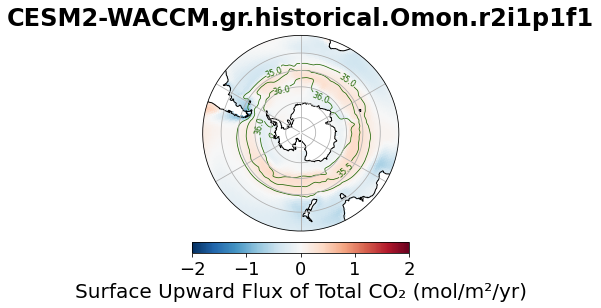

In [46]:
ds = ds = dd_new_new['CESM2-FV2.gr.historical.Omon']

fig, ax = plt.subplots(nrows = 1, ncols = 1,subplot_kw={'projection':ccrs.SouthPolarStereo()})
crs_plot = ccrs.SouthPolarStereo()
crs_source = ccrs.PlateCarree()

ax.set_extent([-180, 180, -90, -30], crs_source)

    
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
    
ax.gridlines()
ax.coastlines()
    
title=name
ax.set_title(title,fontsize=24,pad = 10, fontweight = 'bold')
    
conversion = 3.1536e7 * 22.72

lat = ds.lat.transpose('y','x')
lon = ds.lon.transpose('y','x')
X = lon
Y = lat

Z = ds.fgco2.isel(time = slice(0, 239)).mean('time', keep_attrs=True)*conversion
rho = calc_sigma2(ds.isel(time = slice(0, 239)).isel(lev=0).mean('time', keep_attrs=True))
rho = rho.transpose('x','y')
rho.assign_coords({'lat': Y})
rho.assign_coords({'lon': X})

# rho.lon
# rho
# rho
# # print(Z)
# # print(rho)

    
im = ax.pcolormesh(X,Y,-1*Z,cmap='RdBu_r', transform = crs_source, shading = 'auto', vmin = -2, vmax = 2)
CS = ax.contour(ds['lon'],ds['lat'],rho,transform=crs_source,levels=[35, 35.5, 36],colors='#1d6500', linewidths = 0.75)
# CS2 = ax.contour(ds['lon'],ds['lat'],rho,transform=crs_source,levels=[35.5],colors='#680296', linewidths = 0.75)
# CS3 = ax.contour(ds['lon'],ds['lat'],rho,transform=crs_source,levels=[36],colors='#b9ba02', linewidths = 0.75)
ax.clabel(CS, inline=1, fontsize=8)
    
cbar_label = 'Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)'
cbar = plt.colorbar(im,ax = ax, orientation='horizontal',fraction = 0.05, pad=0.05)
cbar.set_label(cbar_label, fontsize = 20)
cbar.ax.tick_params(labelsize=18)

In [ ]:
ds = dd_new_new['IPSL-CM6A-LR.gn.historical.Omon']

fig, ax = plt.subplots(nrows = 1, ncols = 1,subplot_kw={'projection':ccrs.SouthPolarStereo()})
crs_plot = ccrs.SouthPolarStereo()
crs_source = ccrs.PlateCarree()

ax.set_extent([-180, 180, -90, -30], crs_source)

    
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
    
ax.gridlines()
ax.coastlines()
    
title=name
ax.set_title(title,fontsize=24,pad = 10, fontweight = 'bold')
    
conversion = 3.1536e7 * 22.72

lat = ds.lat.transpose('y','x')
lon = ds.lon.transpose('y','x')
X = lon
Y = lat

Z = ds.fgco2.isel(time = slice(0, 239)).mean('time', keep_attrs=True)*conversion
rho = calc_sigma2(ds.isel(time = slice(0, 239)).isel(lev=0).mean('time', keep_attrs=True))
rho = rho.transpose('x','y')
rho.assign_coords({'lat': Y})
rho.assign_coords({'lon': X})

# rho.lon
# rho
# rho
# # print(Z)
# # print(rho)

    
im = ax.pcolormesh(X,Y,-1*Z,cmap='RdBu_r', transform = crs_source, shading = 'auto', vmin = -2, vmax = 2)
CS = ax.contour(ds['lon'],ds['lat'],rho,transform=crs_source,levels=[35, 35.5, 36],colors='#1d6500', linewidths = 0.75)
# CS2 = ax.contour(ds['lon'],ds['lat'],rho,transform=crs_source,levels=[35.5],colors='#680296', linewidths = 0.75)
# CS3 = ax.contour(ds['lon'],ds['lat'],rho,transform=crs_source,levels=[36],colors='#b9ba02', linewidths = 0.75)
ax.clabel(CS, inline=1, fontsize=8)
    
cbar_label = 'Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)'
cbar = plt.colorbar(im,ax = ax, orientation='horizontal',fraction = 0.05, pad=0.05)
cbar.set_label(cbar_label, fontsize = 20)
cbar.ax.tick_params(labelsize=18)

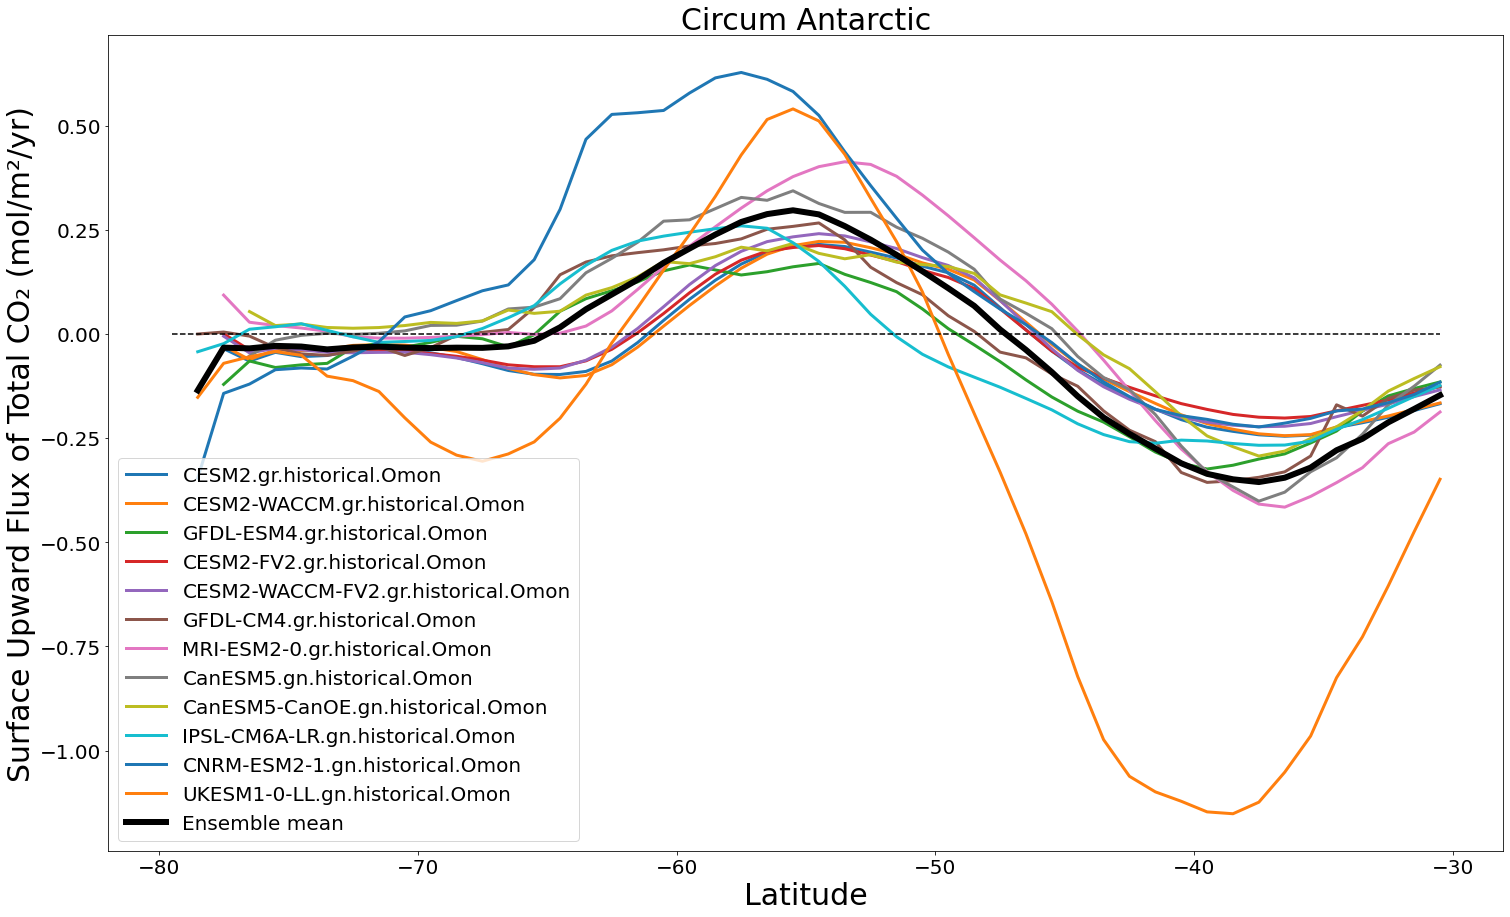

In [20]:
# fig, ax = plt.subplots(nrows = 1, figsize=[18,12])
plt.rc('font', size = 20)
plt.rc('axes', titlesize= 30)    
plt.rc('axes', labelsize= 30)
plt.rc('figure', titlesize=30)
temp={}
yy = dd_new_new['CESM2-FV2.gr.historical.Omon'].lat.y

conversion = 3.1536e7 * 22.72
# 3.1536e7 seconds per year
# 22.72 mol CO2 per kg -- 44.01 gCO2/mol

ax_idx = 0
for name, ds in dd_new_new.items():
    # maybe do mean over the entire circumference so just 
    # take out the where function and mean all x
    ar = -1*ds.fgco2.isel(time = slice(0, 239)).mean(['time', 'x'], keep_attrs=True)*conversion
#     ds.fgco2.where(np.logical_and(ds.lon<=200, ds.lon>=180), drop=True).isel(time = 0).mean('x', keep_attrs=True).plot(label = name, lw = 3)
    plt.plot(yy[10:60], ar[10:60], label = name, lw = 3)
    # adds ar to an array 
    temp[name] = ar
#     print(ds.fgco2.lat.y)
    plt.xlabel('Latitude')
    plt.ylabel('Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)')

mn = np.nanmean(list(temp.values()), axis=0)
plt.plot(yy[10:60], mn[10:60], lw = 6, label = 'Ensemble mean', color = 'black')
plt.xlabel('Latitude')
plt.ylabel('Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)')

zr = xr.zeros_like(dd_new_new['CESM2-FV2.gr.historical.Omon'].fgco2)
zr.isel(x = 0, time = 0)[10:60].plot(linestyle = 'dashed', color = 'black')
plt.xlabel('Latitude')
plt.ylabel('Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)')
# ax = plt.gca
# box = ax.get_position()
# ax.position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='lower left'
#     , borderaxespad=0.
)
plt.title('Circum Antarctic')
plt.rcParams["figure.figsize"] = (25,15)



In [31]:
# fig_1, axarr_1 = plt.subplots(nrows = 7, figsize=[18,12])
plt.rc('font', size = 25)
plt.rc('axes', titlesize= 30)    
plt.rc('axes', labelsize= 30)
plt.rc('figure', titlesize=30)
temp={}
yy = dd_new_new['CESM2-FV2.gr.historical.Omon'].lat.y

conversion = 3.1536e7 * 22.72
# 3.1536e7 seconds per year
# 22.72 mol CO2 per kg -- 44.01 gCO2/mol

ax_idx = 0
for name, ds in dd_new_new.items():
    # maybe do mean over the entire circumference so just 
    # take out the where function and mean all x
    ar = -1*ds.fgco2.isel(time = slice(0, 239)).mean(['time', 'x'], keep_attrs=True)*conversion
#     ds.fgco2.where(np.logical_and(ds.lon<=200, ds.lon>=180), drop=True).isel(time = 0).mean('x', keep_attrs=True).plot(label = name, lw = 3)
#     plt.plot(yy[0:50], ar[0:50], label = name, lw = 3)
    # adds ar to an array 
    temp[name] = ar
#     print(ds.fgco2.lat.y)
#     plt.xlabel('Latitude')
#     plt.ylabel('Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)')


mn = np.nanmean(list(temp.values()), axis=0)
sd = np.std(list(temp.values()))
# plt.plot(yy[0:50], mn[0:50], lw = 6, label = 'Ensemble mean', color = 'black')
# plt.xlabel('Latitude')
# plt.ylabel('Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)')

# zr = xr.zeros_like(dd_new_new['CESM2-FV2.gr.historical.Omon'].fgco2)
# zr.isel(x = 0, time = 0)[0:50].plot(linestyle = 'dashed', color = 'black')
# plt.xlabel('Latitude')
# plt.ylabel('Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)')
# # ax = plt.gca
# # box = ax.get_position()
# # ax.position([box.x0, box.y0, box.width * 0.8, box.height])
# plt.legend(
# #     bbox_to_anchor=(1.05, 1), 
#     loc='upper left'
# #     , borderaxespad=0.
# )
# plt.title('Circum Antarctic')
# plt.rcParams["figure.figsize"] = (25,20)

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [34]:
sd = np.std(list(temp.values()), axis=0)

Text(0, 0.5, 'Surface Upward Flux of Total CO₂ (mol/m²/yr)')

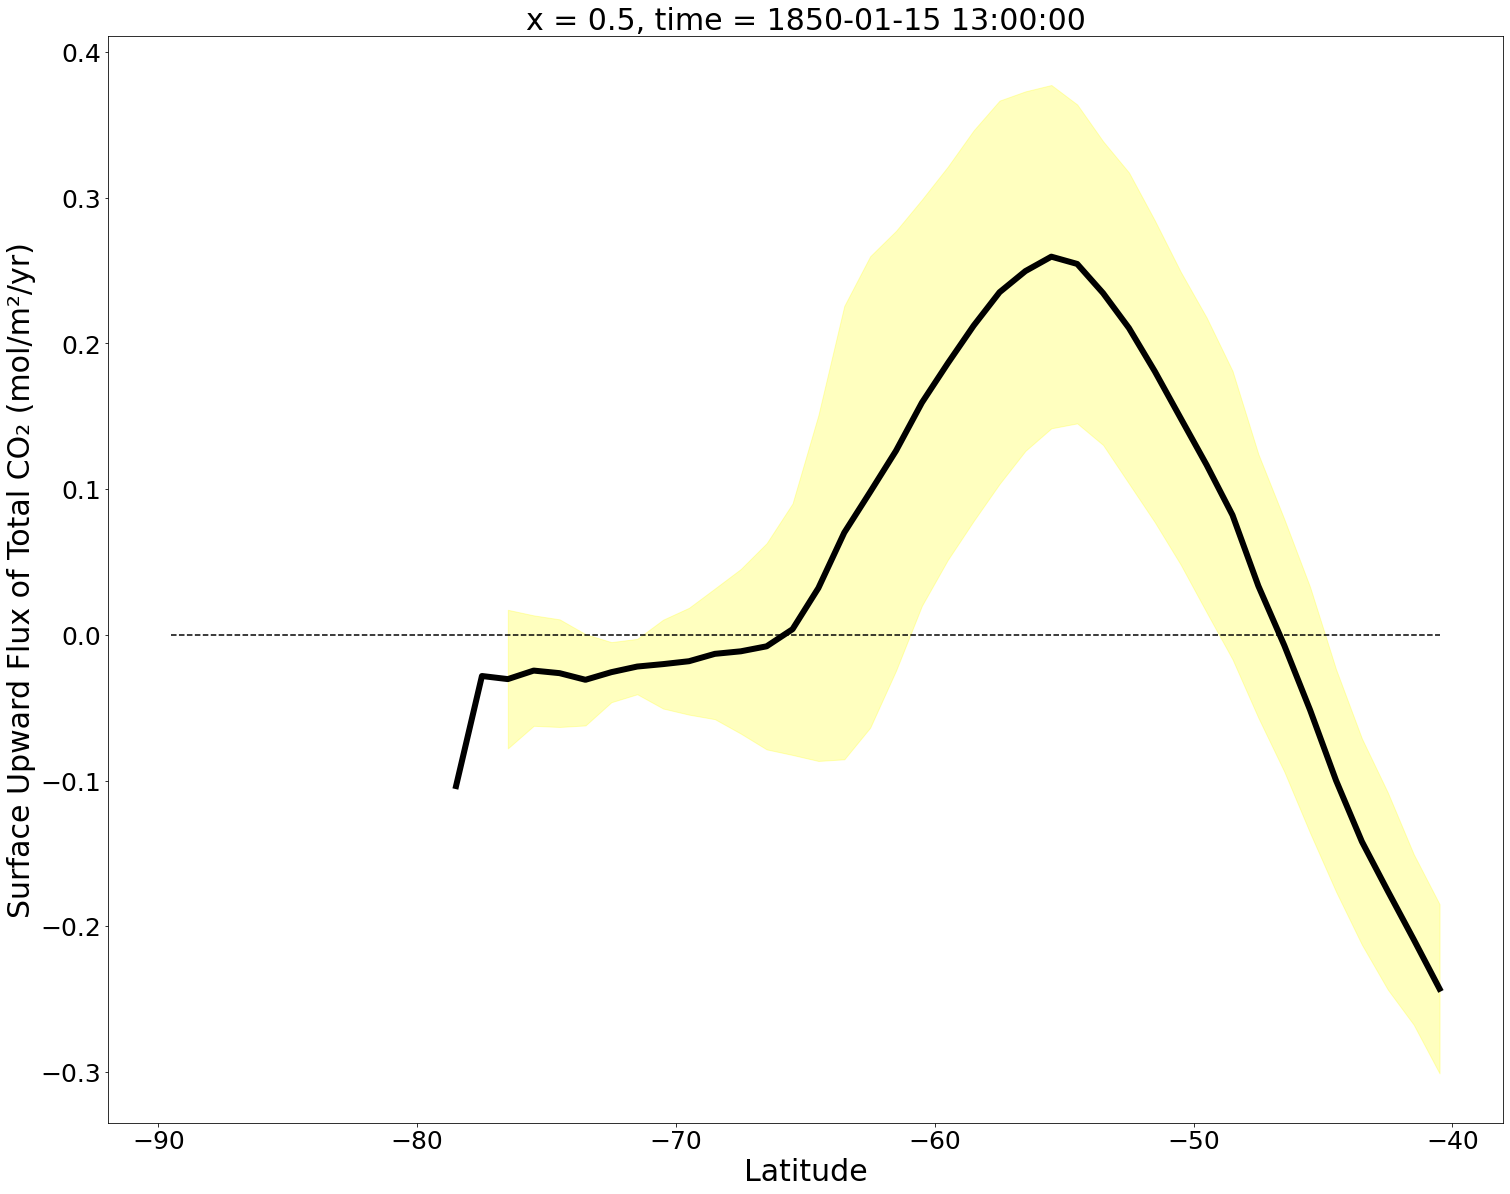

In [47]:
plt.plot(yy[0:50], mn[0:50], lw = 6, label = 'Ensemble mean', color = 'black')
# plt.plot(yy[0:50], mn[0:50]+sd[0:50], lw = 6, label = 'Ensemble mean', color = 'black')
# plt.plot(yy[0:50], mn[0:50]-sd[0:50], lw = 6, label = 'Ensemble mean', color = 'black')
plt.fill_between(yy[0:50], mn[0:50]+sd[0:50], mn[0:50]-sd[0:50], color = 'yellow', alpha = 0.25)

zr = xr.zeros_like(dd_new_new['CESM2-FV2.gr.historical.Omon'].fgco2)
zr.isel(x = 0, time = 0)[0:50].plot(linestyle = 'dashed', color = 'black')
plt.xlabel('Latitude')
plt.ylabel('Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)')

In [58]:
# fig_1, axarr_1 = plt.subplots(nrows = 7, figsize=[18,12])
# plt.rc('font', size = 25)
# plt.rc('axes', titlesize= 30)    
# plt.rc('axes', labelsize= 30)
# plt.rc('figure', titlesize=30)
temp={}
yy = dd_new_new['CESM2-FV2.gr.historical.Omon'].lat.y

conversion = 3.1536e7 * 22.72
# 3.1536e7 seconds per year
# 22.72 mol CO2 per kg -- 44.01 gCO2/mol

# ax_idx = 0
# for name, ds in dd_new_new.items():
#     # maybe do mean over the entire circumference so just 
#     # take out the where function and mean all x
#     ar = -1*ds.fgco2.isel(time = slice(0, 239)).mean(['time', 'x'], keep_attrs=True)*conversion
#     ds.fgco2.where(np.logical_and(ds.lon<=200, ds.lon>=180), drop=True).isel(time = 0).mean('x', keep_attrs=True).plot(label = name, lw = 3)
#     plt.plot(yy[0:50], ar[0:50], label = name, lw = 3)
#     # adds ar to an array 
#     temp[name] = ar
# #     print(ds.fgco2.lat.y)
#     plt.xlabel('Latitude')
#     plt.ylabel('Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)')


mn = np.nanmean(list(temp.values()), axis=0)
plt.plot(yy[0:50], mn[0:50], lw = 6, label = 'Ensemble mean', color = 'black')


# sd = np.std(list(temp.values()), axis = 0)
# # plt.xlabel('Latitude')
# # plt.ylabel('Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)')
# sd_up = mn+sd
# sd_down = mn-sd
# plt.fill_between(yy[0:50], sd_up[0:50], sd_down[0:50], color = 'yellow', alpha = 0.25)

# zr = xr.zeros_like(dd_new_new['CESM2-FV2.gr.historical.Omon'].fgco2)
# zr.isel(x = 0, time = 0)[0:50].plot(linestyle = 'dashed', color = 'black')
# plt.xlabel('Latitude')
# plt.ylabel('Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)')
# # ax = plt.gca
# # box = ax.get_position()
# # ax.position([box.x0, box.y0, box.width * 0.8, box.height])
# plt.legend(
# #     bbox_to_anchor=(1.05, 1), 
#     loc='upper left'
# #     , borderaxespad=0.
# )
# plt.title('Circum Antarctic')
# # plt.rcParams["figure.figsize"] = (25,20)

IndexError: invalid index to scalar variable.

In [19]:
print('kg/m\u2082')

kg/m₂


In [1]:
import os
PANGEO_SCRATCH = os.environ['PANGEO_SCRATCH']
# -> gs://pangeo-scratch/<username>
import fsspec
mapper = fsspec.get_mapper(f'{PANGEO_SCRATCH}/sub/path')
# mapper can now be to read / write zarr stores

In [28]:
PANGEO_SCRATCH

'gs://pangeo-scratch/abby-baskind/'

In [29]:
os.environ.get('PANGEO_SCRATCH')

'gs://pangeo-scratch/abby-baskind/'

In [27]:
ax_idx = 1
for name, ds in dd_new_new.items():
    rho = gsw.sigma2(ds.so.isel(lev = 0, time = slice(0,239)).mean('time',keep_attrs=True),ds.thetao.isel(lev = 0, time = slice(0,239)).mean('time',keep_attrs=True))
    rho.to_netcdf('pangeo-scratch/abby-baskind/rho'+str(ax_idx)+'.nc')
    ax_idx += 1

PermissionError: [Errno 13] Permission denied: b'/home/jovyan/project/seniorthesis/notebooks/pangeo-scratch/abby-baskind/rho1.nc'

In [20]:
density.to_netcdf('gs://pangeo-scratch/abby-baskind/rho.nc')

AttributeError: 'dict' object has no attribute 'to_netcdf'

SyntaxError: invalid syntax (<ipython-input-23-451b9269c988>, line 1)